# Training Data Preprocessing

This notebook contains data cleaning and feature engineering for the training data.

#### To-do:

- drop irrelevant columns
- deal with nulls/missing data
- string cleaning of names
- explore combining target classes down to two classes
- rename features

- **REMEMBER TO CONDUCT THE SAME DATA CLEANING TO THE TEST SET AS WELL**


In [59]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from skrub import SimilarityEncoder
from fancyimpute import IterativeImputer

In [60]:
# Importing the custom functions
import sys
import os 

sys.path.append(os.path.abspath('../src'))

from utils import *

In [85]:
# Set max display options so that I can see everything I need to see
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

In [61]:
df_train_raw = pd.read_csv('../data/processed/training_set_full.csv')
df_test_raw = pd.read_csv('../data/processed/test_set.csv')

---

## Drop Unneeded Columns

During EDA, I went through all of the features in the data and made an initial determination on which features to keep and which to drop. Those determinations are informing this part of data cleaning.

In [62]:
# Dropping the columns that are not needed based on my EDA
df_train = df_train_raw.drop(columns=['id', 'wpt_name', 'num_private', 'subvillage', 'ward', 'recorded_by', 'scheme_name', 
                            'scheme_management', 'water_quality', 'waterpoint_type_group', 'quantity_group', 'region_code', 
                            'extraction_type', 'extraction_type_group', 'payment', 'source_class', 'source_type', 'amount_tsh'])

In [63]:
# Same for the test set
df_test = df_test_raw.drop(columns=['id', 'wpt_name', 'num_private', 'subvillage', 'ward', 'recorded_by', 'scheme_name', 
                            'scheme_management', 'water_quality', 'waterpoint_type_group', 'quantity_group', 'region_code', 
                            'extraction_type', 'extraction_type_group', 'payment', 'source_class', 'source_type', 'amount_tsh'])
                            

In [64]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          59400 non-null  object 
 1   funder                 55763 non-null  object 
 2   gps_height             38962 non-null  float64
 3   installer              55745 non-null  object 
 4   longitude              57588 non-null  float64
 5   latitude               57588 non-null  float64
 6   basin                  59400 non-null  object 
 7   region                 59400 non-null  object 
 8   district_code          59400 non-null  int64  
 9   lga                    59400 non-null  object 
 10  population             38019 non-null  float64
 11  public_meeting         56066 non-null  object 
 12  permit                 56344 non-null  object 
 13  construction_year      38691 non-null  float64
 14  extraction_type_class  59400 non-null  object 
 15  ma

Further pruning will likely happen when I begin feature engineering. I'm specifically thinking of 'lga', 'installer', 'funder' and the coordinate features. The first three due to their high cardinality and the coordinates because I'm not sure that level of geographic specificity is needed for an intial classification model. 

---

## Dealing with Missing Values

In [65]:
import missingno as msno

### Missing data overview

In [66]:
missing_abs = df_train.isna().sum()
missing_abs.sort_values(ascending=False).head(10)

population           21381
construction_year    20709
gps_height           20438
installer             3655
funder                3637
public_meeting        3334
permit                3056
longitude             1812
latitude              1812
management_group         0
dtype: int64

In [67]:
missing = round((df_train.isna().sum() / len(df_train)) * 100, 2)
missing = missing.sort_values(ascending=False)
missing.head(10)

population           35.99
construction_year    34.86
gps_height           34.41
installer             6.15
funder                6.12
public_meeting        5.61
permit                5.14
longitude             3.05
latitude              3.05
management_group      0.00
dtype: float64

<Axes: >

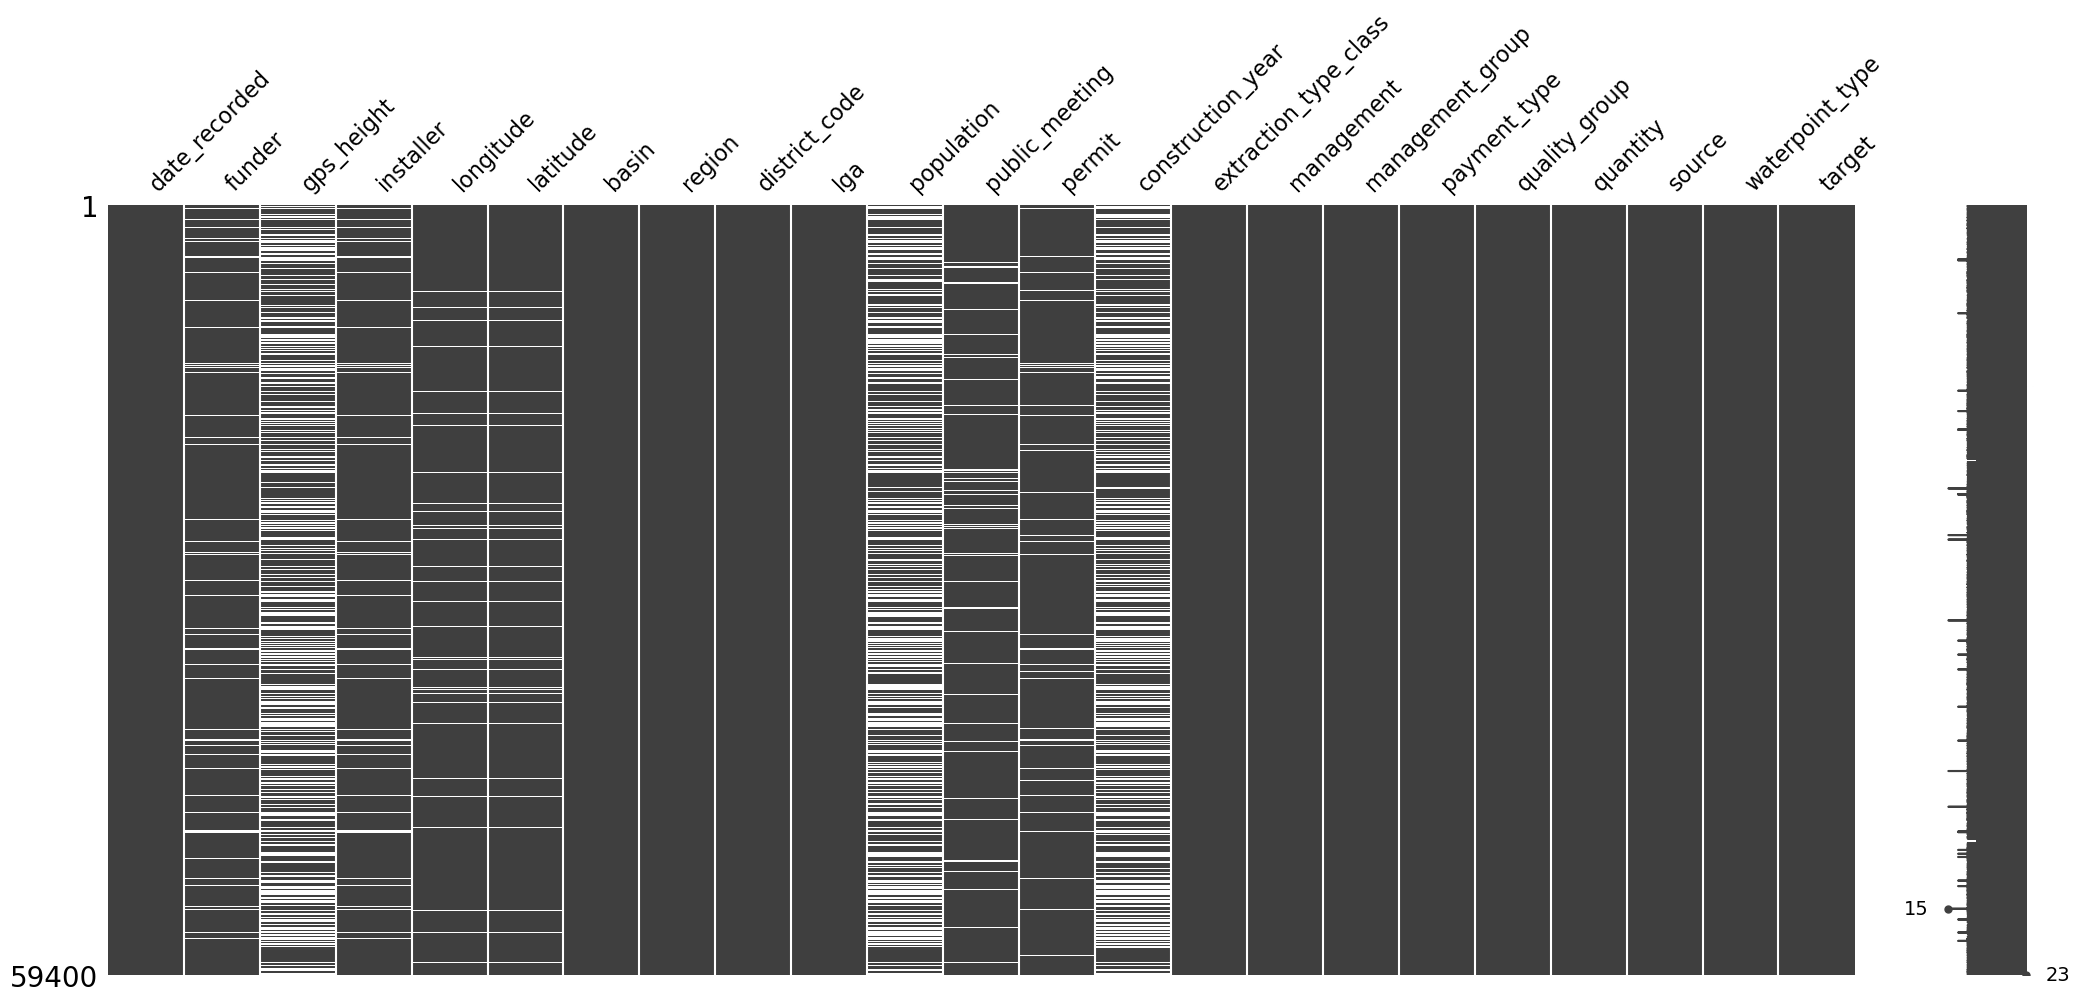

In [68]:
# Visualizing the missing values in the dataset
msno.matrix(df_train)

'population' and 'construction_year' have the highest quantity of missing values and there seems to be a relation between where they are missing in the data. Let's verify this.

<Axes: >

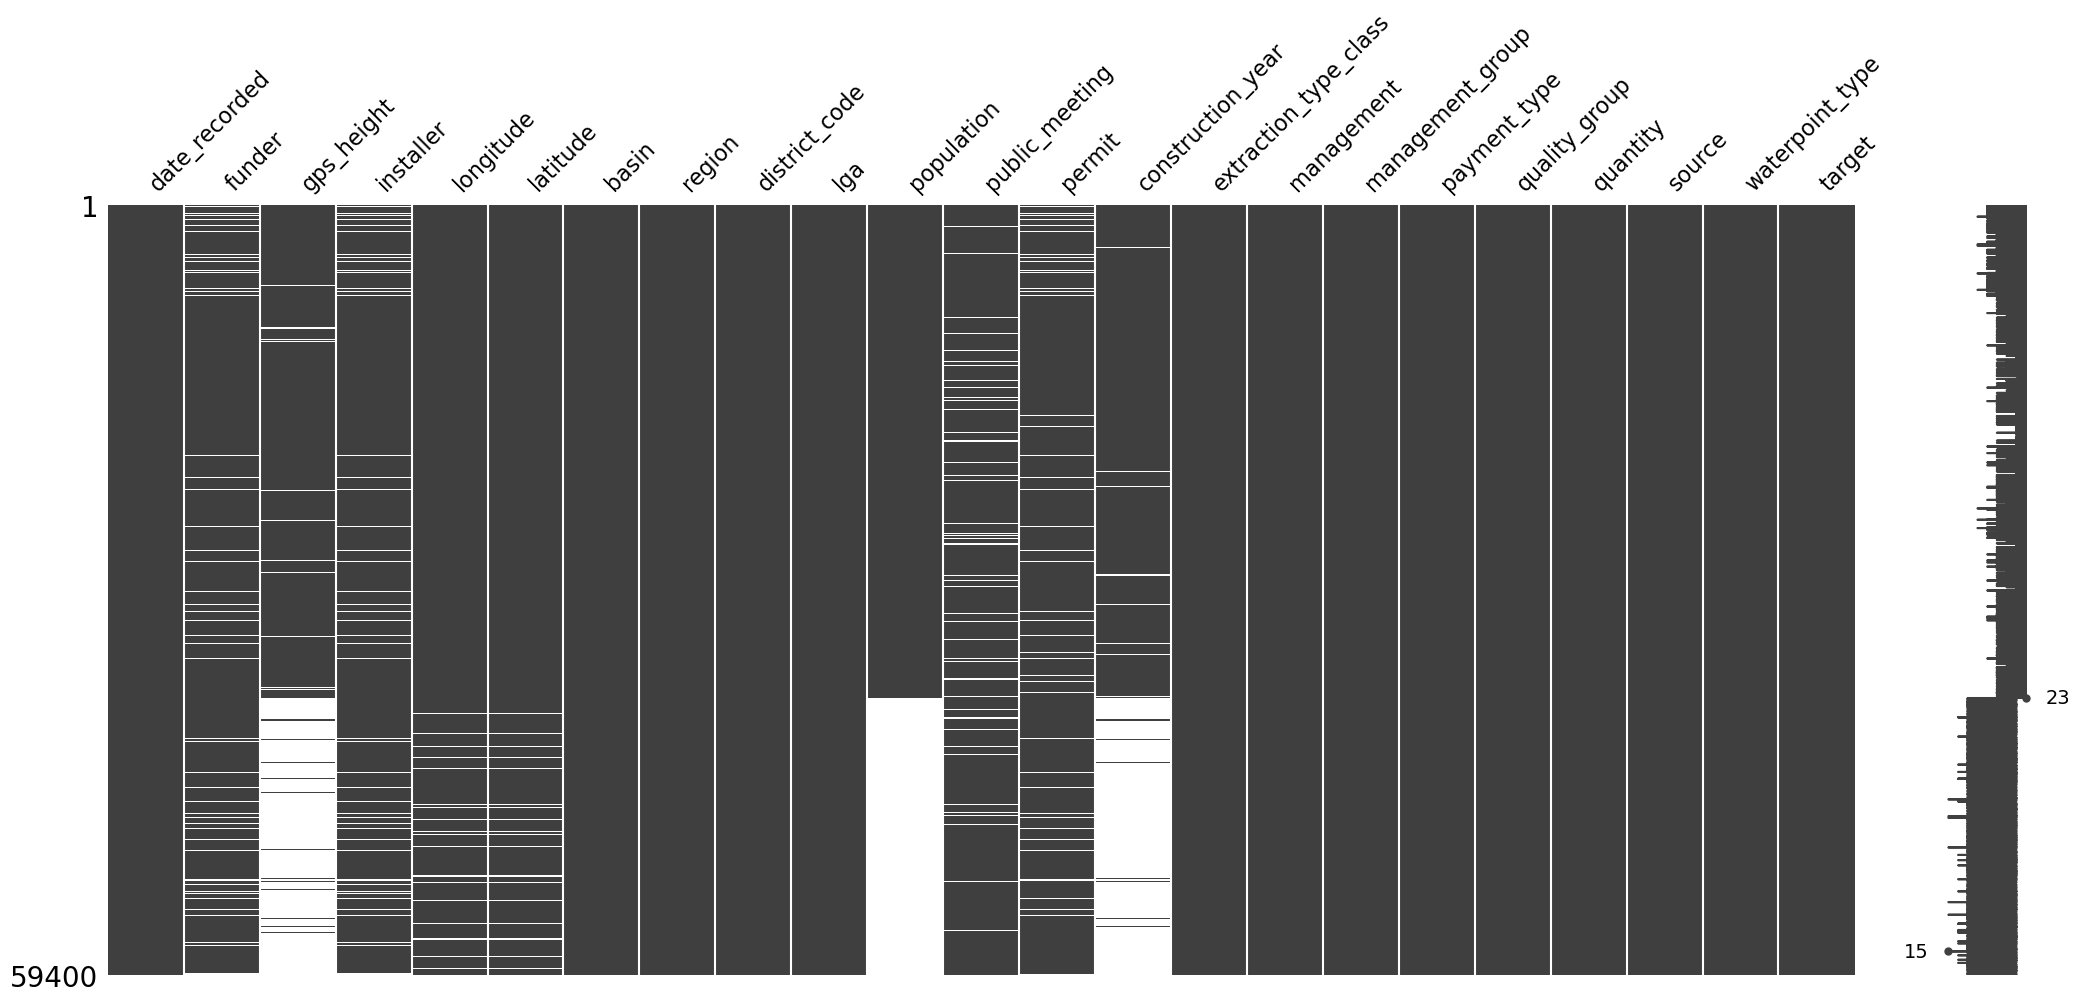

In [69]:
temp = df_train.sort_values('population')
msno.matrix(temp)

There definitely seems to be a discernable pattern in where data is missing in the dataset. 'funder' and 'installer' are missing data on nearly the exact same rows. The same applies to longitude and latitude as I discovered in EDA already. 'population' and 'construction_year' are also missing data in nearly the same exact rows. Now, which strategy to use for dealing with all this missing data?

### Strategy 1: Naive approach - Dropping all records with missing values

The simplest approach is to just drop all nulls.

In [70]:
# Make a copy of df_train to test dropping all nulls
strat1 = df_train.copy()

In [71]:
# Drop all null values
strat1 = strat1.dropna()

In [72]:
# 32543 rows left, not bad on a macro level
strat1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32543 entries, 0 to 59399
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          32543 non-null  object 
 1   funder                 32543 non-null  object 
 2   gps_height             32543 non-null  float64
 3   installer              32543 non-null  object 
 4   longitude              32543 non-null  float64
 5   latitude               32543 non-null  float64
 6   basin                  32543 non-null  object 
 7   region                 32543 non-null  object 
 8   district_code          32543 non-null  int64  
 9   lga                    32543 non-null  object 
 10  population             32543 non-null  float64
 11  public_meeting         32543 non-null  object 
 12  permit                 32543 non-null  object 
 13  construction_year      32543 non-null  float64
 14  extraction_type_class  32543 non-null  object 
 15  managem

In [73]:
# Export to csv
strat1.to_csv('../data/processed/train_all_nulls_dropped.csv', index=False)

In [74]:
# Same operation for the test set
strat1_test = df_test.copy()
strat1_test = strat1_test.dropna()

In [75]:
# Export to csv
strat1_test.to_csv('../data/processed/test_all_nulls_dropped.csv', index=False)

### Strategy 2: All kinds imputing [INCOMPLETE]

In [76]:
# KDE plot comparing the original and imputed dataset
def impute_checker (feature, imputed_dataset, title):
  df_train[feature].plot(kind='kde', c='black')
  imputed_dataset[feature].plot(kind='kde', style = "--", c= '#66c2a5')
  labels = ['Original df', 'Imputed df']
  plt.legend(labels)
  plt.xlabel(feature)
  plt.title(title)
  plt.show()


#### MICE imputation

Testing out MICE imputation.

In [89]:
strat2_train = df_train.copy()

In [91]:
# Drop categorical columns with high cardinality
strat2_train = strat2_train.drop(columns=['funder', 'installer', 'lga', 'region'])

strat2_train_features = strat2_train
# Create a list of all categorical features
categorical_cols = [cname for cname in strat2_train_features.columns if
                    strat2_train_features[cname].dtype == "object"]

In [92]:
# Encode categorical columns 
for col in categorical_cols:
  le = LabelEncoder()
  strat2_train_features[col] = le.fit_transform(strat2_train_features[col])
 

In [93]:
# Create MICE imputer
mice_imputer = IterativeImputer()

# Fit and transform on train
strat2_train_features.iloc[:, :] = (mice_imputer.fit_transform(strat2_train_features))

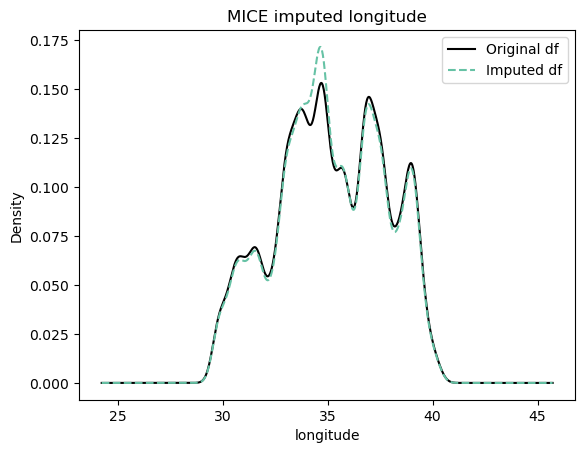

In [94]:
# MICE imputing longitude seems okay
impute_checker('longitude', strat2_train_features, 'MICE imputed longitude')

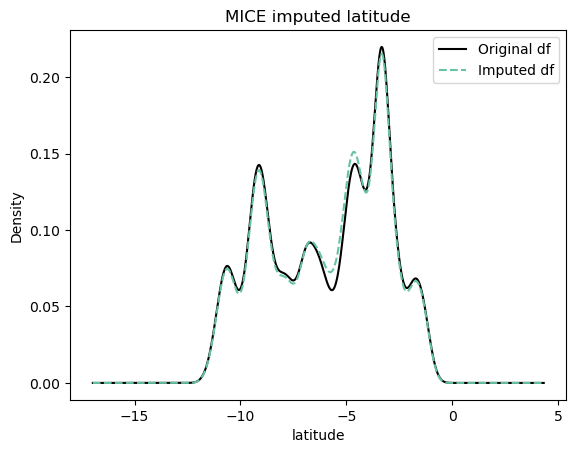

In [95]:
# MICE imputing latitude also seems okay
impute_checker('latitude', strat2_train_features, 'MICE imputed latitude')

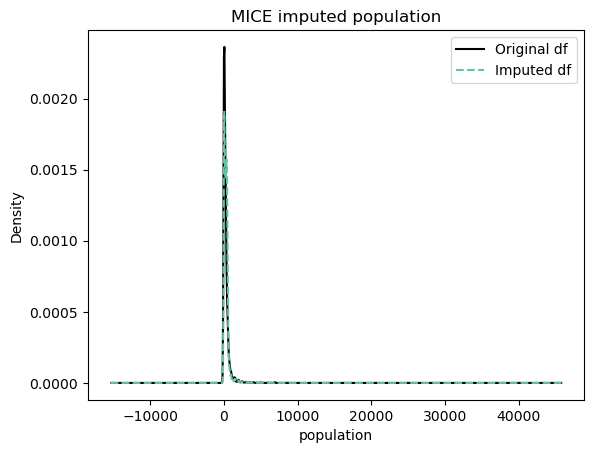

In [96]:
# MICE imputing population is not really achieving the desired effect
impute_checker('population', strat2_train_features, 'MICE imputed population')

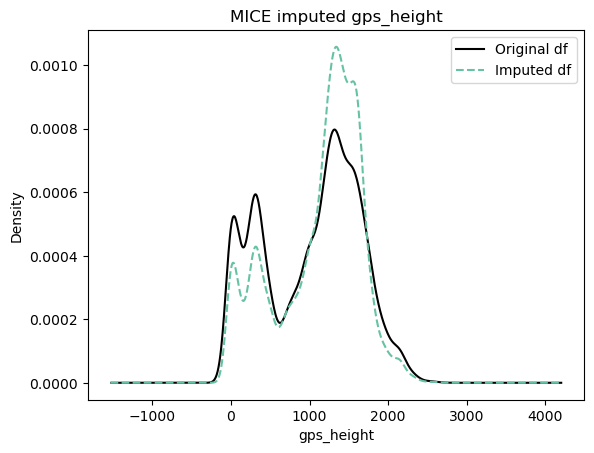

In [97]:
# MICE imputing population is not really achieving the desired effect
impute_checker('gps_height', strat2_train_features, 'MICE imputed gps_height')

MICE imputing missing values in numerical categories looks ok for the coordinates but less effective for 'population' and 'gps_height' introducing a lot of noise.

#### Impute by nearby samples

### Strategy 3: Combination of strategies 1 and 2 [TO-DO]

A little more finesse than only dropping nulls or only imputing all missing values.

---

## String Cleaning

All categorical columns with names as values
- funder
- installer
- basin
- region
- lga
- management


## Target Variable: From 3 Classes to 2

Prolly merge 'functional needs repair' into 'non functional'.

In [86]:
df_train_raw.loc[df_train_raw['target'] == 'functional needs repair']

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target
18,34169,0.0,2011-07-22,Hesawa,1162.0,DWE,32.920154,-1.947868,Ngomee,0,Lake Victoria,Center,Mwanza,19,1,Ukerewe,Ilangala,1000.0,NaN,GeoData Consultants Ltd,NaN,NaN,True,1999.0,other,other,other,vwc,user-group,never pay,never pay,milky,milky,insufficient,insufficient,spring,spring,groundwater,other,other,functional needs repair
22,58500,0.0,2011-10-04,Unicef,1510.0,DWE,34.586901,-8.980014,Shuleni,0,Rufiji,Mkanivega,Iringa,11,4,Njombe,Usuka,350.0,True,GeoData Consultants Ltd,WUA,wanging'ombe water supply s,True,1978.0,gravity,gravity,gravity,wua,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional needs repair
25,22308,0.0,2013-02-25,Government Of Tanzania,1273.0,DWE,37.422751,-3.317536,Kwa Tukai,0,Pangani,Kitereni,Kilimanjaro,3,4,Moshi Rural,Kimochi,140.0,True,GeoData Consultants Ltd,VWC,Komaka mandaka,True,1974.0,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional needs repair
32,57238,0.0,2013-03-19,Government Of Tanzania,1481.0,DWE,37.492334,-3.290627,Kwa Philip Lyimo,0,Pangani,Mosheni,Kilimanjaro,3,4,Moshi Rural,Kilema Kati,180.0,False,GeoData Consultants Ltd,Other,Mae pipeline,True,1972.0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,other,other,functional needs repair
44,1843,20.0,2013-03-18,Government Of Tanzania,1007.0,DWE,36.806079,-3.478559,Kwa Bariki,0,Pangani,Marurani Juu,Arusha,2,2,Arusha Rural,Nduruma,100.0,True,GeoData Consultants Ltd,VWC,Machumba estate pipe line,True,2000.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59322,44114,6000.0,2013-02-14,Unicef,532.0,UNICEF,36.985457,-11.467225,Misepelo,0,Ruvuma / Southern Coast,Kariakoo,Ruvuma,10,1,Tunduru,Nalasi,1.0,True,GeoData Consultants Ltd,VWC,NaN,False,1999.0,swn 80,swn 80,handpump,vwc,user-group,pay annually,annually,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional needs repair
59328,512,2000.0,2013-01-29,Tcrs,1497.0,TCRS,34.799452,-4.349604,Mitogo,0,Internal,Mtundua,Singida,13,1,Iramba,Ilunda,195.0,True,GeoData Consultants Ltd,VWC,NaN,True,1997.0,nira/tanira,nira/tanira,handpump,vwc,user-group,pay when scheme fails,on failure,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59333,21732,50.0,2013-02-13,Kiuma,706.0,KIUMA,36.961390,-11.305345,Kwa Rashid Swalehe,0,Ruvuma / Southern Coast,Ruvuma,Ruvuma,10,1,Tunduru,Marumba,1.0,True,GeoData Consultants Ltd,VWC,Mbati Water Supply,False,2011.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional needs repair
59345,68576,600.0,2013-01-25,Isf,962.0,DWE,29.729909,-4.801508,Tupendane,0,Lake Tanganyika,Kabanga,Kigoma,16,3,Kigoma Rural,Mahembe,500.0,True,GeoData Consultants Ltd,WUG,Mkongoro Two,True,2008.0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe multiple,communal standpipe,funct